In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Import Data

Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Read File

In [ ]:
# Specify the file path within your Google Drive
file_path = '/content/drive/My Drive/Colab Notebooks/Skin Cancer Classification/hmnist_28_28_RGB.csv'  # Replace with your actual file path

# Read the file using Pandas (assuming it's a CSV file)
df = pd.read_csv(file_path)

# Data Preprocessing

Take out the label

In [ ]:
y = df['label']
x = df.drop(columns = ['label'])

In [ ]:
print(x.shape)

(10015, 2352)


Oversample to handle class imbalance

In [ ]:
#from imblearn.over_sampling import RandomOverSampler
#oversample = RandomOverSampler()
#x,y  = oversample.fit_resample(x,y)

Specify Labels

In [ ]:
print(y.nunique())

7


In [ ]:
print(y.value_counts())
#nv       6705 benign
#mel      1113 malignant
#bkl      1099 benign
#bcc       514 malignant
#akiec     327 malignant
#vasc      142 benign
#df        115 benign

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64


Replace 4, 2, 5, 3 with benign (0), and rest with malignant (1)

In [ ]:
# Replace values 1, 6, 0 with 1
y.replace({1: 1, 6: 1, 0: 1}, inplace=True)

# Replace values 4, 2, 5, and 3 with 0
y.replace({4: 0, 2: 0, 5: 0, 3: 0}, inplace=True)

In [ ]:
print(y.value_counts())
# benign 8061
# malignant 1954

0    8061
1    1954
Name: label, dtype: int64


Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)

In [ ]:
print(y.value_counts())

0    8061
1    8061
Name: label, dtype: int64


Reshape data

In [ ]:
x = np.array(x).reshape(-1,28,28,3)
print('Shape of X :',x.shape)

Shape of X : (16122, 28, 28, 3)


Convert Shape

In [ ]:
from scipy.ndimage import zoom

images = x

# Define the desired size (224x224)
desired_size = (72,72)

# Upscale the images using interpolation
upscaled_images = np.zeros((images.shape[0],) + desired_size + (3,))
for i in range(images.shape[0]):
    for channel in range(3):
        upscaled_images[i, :, :, channel] = zoom(images[i, :, :, channel],
                                                 (desired_size[0] / images.shape[1], desired_size[1] / images.shape[2]))
print(upscaled_images.shape)

(16122, 72, 72, 3)


In [ ]:
x = upscaled_images
print(x.shape)

(16122, 72, 72, 3)


Standardization

In [ ]:
x = (x-np.mean(x))/np.std(x)

Train-Test Splitting

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)

In [ ]:
print(Y_train.value_counts())
print(Y_test.value_counts())

1    6451
0    6446
Name: label, dtype: int64
0    1615
1    1610
Name: label, dtype: int64


# Model Training

In [ ]:
#from tensorflow.python.keras.applications import ResNet50
from keras.applications import ResNet50

In [ ]:
# Clear the TensorFlow session
tf.keras.backend.clear_session()

Pre-trained RestNet Model

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(72, 72, 3)) # do not include fully connected layers
base_model.trainable = False # Freezing CNN layers

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 72, 72, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 78, 78, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 36, 36, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 36, 36, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
from keras import layers, models
from keras.layers import GlobalAveragePooling2D, BatchNormalization

model = models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')

])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 3

In [ ]:
model.compile(
    optimizer='adam',
    loss= tf.keras.losses.binary_crossentropy,
    metrics=['accuracy']
)

In [ ]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                              monitor='val_acc', mode='max',
                                              verbose=1)

In [ ]:
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 30,
                    callbacks=[callback])

Epoch 1/30
81/81 [==============================] - ETA: 0s - loss: 0.5130 - accuracy: 0.7455
Epoch 1: saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


81/81 [==============================] - 33s 208ms/step - loss: 0.5130 - accuracy: 0.7455 - val_loss: 0.6437 - val_accuracy: 0.5764
Epoch 2/30
80/81 [============================>.] - ETA: 0s - loss: 0.4282 - accuracy: 0.8026
Epoch 2: saving model to best_model.h5
81/81 [==============================] - 9s 110ms/step - loss: 0.4284 - accuracy: 0.8023 - val_loss: 0.5463 - val_accuracy: 0.7523
Epoch 3/30
80/81 [============================>.] - ETA: 0s - loss: 0.3712 - accuracy: 0.8357
Epoch 3: saving model to best_model.h5
81/81 [==============================] - 11s 139ms/step - loss: 0.3709 - accuracy: 0.8360 - val_loss: 0.4925 - val_accuracy: 0.7895
Epoch 4/30
80/81 [============================>.] - ETA: 0s - loss: 0.3287 - accuracy: 0.8572
Epoch 4: saving model to best_model.h5
81/81 [==============================] - 11s 135ms/step - loss: 0.3297 - accuracy: 0.8567 - val_loss: 0.4400 - val_accuracy: 0.8016
Epoch 5/30
80/81 [============================>.] - ETA: 0s - loss: 0.2922

# Plot Model Progression

Accuracy (training vs validation dataset)

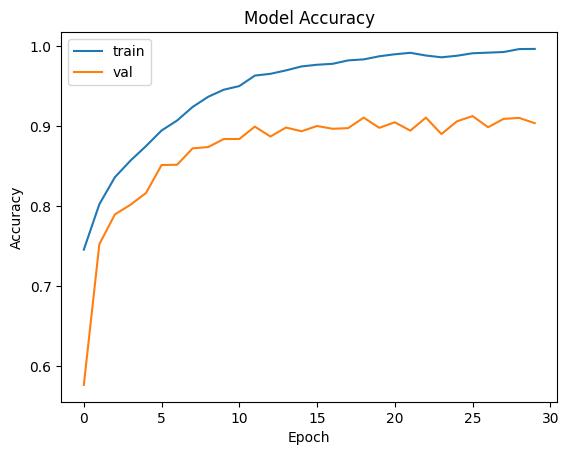

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Loss (training vs validation dataset)

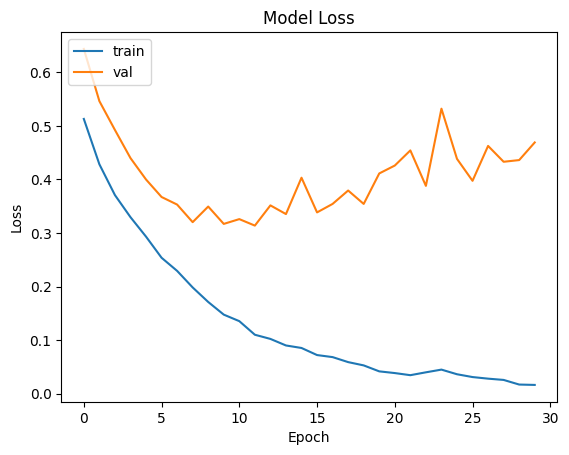

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Load best model weights

In [ ]:
model.load_weights('best_model.h5')

Print model weights

In [ ]:
# Load your pre-trained model (replace 'model.h5' with your model's filename)
best_model = tf.keras.models.load_model('best_model.h5')
# Define the path where you want to save the model
model_save_path = '/content/drive/My Drive/Colab Notebooks/Skin Cancer Classification/'

# Save the best model to Google Drive
best_model.save(model_save_path + 'best_model_resnet50.h5')

# Get the list of all layers in the model
all_layers = best_model.layers

# Loop through the layers and print their weights if they have any
for layer in all_layers:
    if layer.weights:
        print(f"Layer: {layer.name}")
        for weight in layer.weights:
            print(f"  {weight.name}:")
            print(weight.numpy())

Streaming output truncated to the last 5000 lines.
 0.7317073  1.11929    0.82440865 1.0328083  0.3156103  1.0203997
 1.0336274  0.7690285  0.5265387  0.5789124  0.66501635 0.7955453
 1.2293016  0.82957655 0.44594756 1.0014651  0.97415143 0.7699116
 0.42558652 0.8930488  0.63419163 0.6907022  0.81985676 0.93255305
 0.6724639  0.5644526  0.53095245 0.73103094 1.3023069  1.1407762
 0.5959262  0.966253   0.71023595 0.86503136 0.86360997 0.6071058
 0.6826196  0.81642514 1.1628157  0.76432014 0.86442214 0.9287848
 0.78781456 0.5482268  1.0113289  0.67334116 1.0447795  0.75746965
 0.60305715 0.7202524  0.6945901  0.6533382  0.71885383 0.9900192
 0.6957288  0.631031   0.8293259  0.7832494  0.71370614 0.845464
 1.0617064  1.9461508  1.831571   0.8557668  0.84223926 0.86424017
 1.2587334  0.713278   0.8799454  0.7460647  0.64072156 1.2293186
 0.9457296  0.64095587 0.97989213 0.59290785 0.6709213  1.2976106
 0.49106884 0.9881034  0.60010463 1.098794   0.982376   0.47326127
 1.167803   0.8837577 

# Model Testing

In [ ]:
#loss, acc = model.evaluate(X_test, Y_test, verbose=2)

In [ ]:
import sklearn.metrics as metrics

y_pred_ohe = model.predict(X_test)
#y_pred_labels = np.argmax(y_pred_ohe, axis=1)

101/101 [==============================] - 4s 23ms/step


In [ ]:
threshold = 0.9
y_pred_labels = (y_pred_ohe >= threshold).astype(int)

In [ ]:
# Save predictions as a NumPy array
np.save('resnet50_predictions.npy', y_pred_labels)

In [ ]:
print(y_pred_labels)

[[0]
 [0]
 [1]
 ...
 [0]
 [1]
 [0]]


In [ ]:
confusion_matrix = metrics.confusion_matrix(y_true=Y_test, y_pred=y_pred_labels)
print(confusion_matrix)

[[1471  144]
 [  69 1541]]


In [ ]:
from sklearn.metrics import classification_report
class_labels = ['benign', 'malignant']
report = classification_report(Y_test, y_pred_labels, target_names = class_labels)
print(report)

              precision    recall  f1-score   support

      benign       0.96      0.91      0.93      1615
   malignant       0.91      0.96      0.94      1610

    accuracy                           0.93      3225
   macro avg       0.93      0.93      0.93      3225
weighted avg       0.93      0.93      0.93      3225



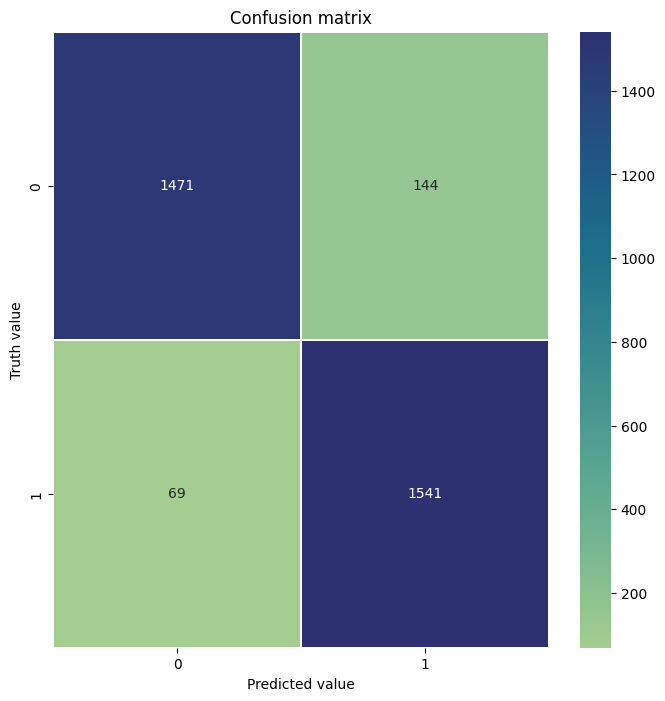

In [ ]:
import seaborn as sns

cm = confusion_matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, fmt='.0f', cmap="crest", annot=True, linewidths=0.2)
plt.title('Confusion matrix')
plt.xlabel('Predicted value')
plt.ylabel('Truth value')
plt.show()
#print(confusion_matrix(Y_test, y_pred_labels))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc


# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(Y_test, y_pred_labels)
precision = precision_score(Y_test, y_pred_labels)
recall = recall_score(Y_test, y_pred_labels)
f1 = f1_score(Y_test, y_pred_labels)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.93
Precision: 0.91
Recall: 0.96
F1-score: 0.94


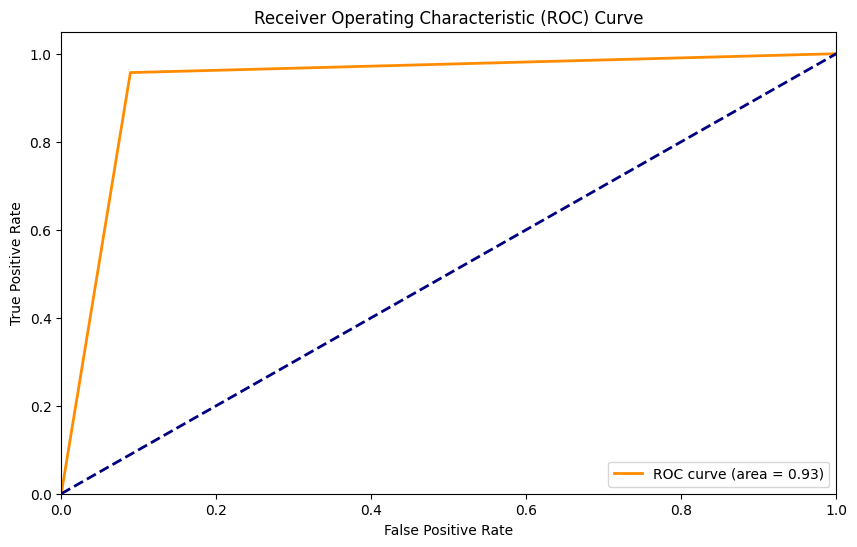

In [ ]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(Y_test, y_pred_labels)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()